## Классификация постов
Используется три архитектуры нейронных сетей:
- Одномерная сверточная нейросеть
- Рекуррентная нейросеть LSTM
- Рекуррентная нейросеть GRU

In [1]:
!pip show tensorflow

Name: tensorflow
Version: 2.12.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, jax, keras, libclang, numpy, opt-einsum, packaging, protobuf, setuptools, six, tensorboard, tensorflow-estimator, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: dopamine-rl


tf-nightly нужен, т.к. f.keras.metrics.F1Score работает только для tf-nightly. См. https://www.tensorflow.org/api_docs/python/tf/keras/metrics/F1Score

In [2]:
!pip install tf-nightly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.2/488.2 MB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 95.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 114.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 441.0/441.0 kB 45.9 MB/s eta 0:00:00
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 23.3.3
    Uninstalling flatbuffers-23.3.3:
      Successfully uninstalled flatbuffers-23.3.3


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, MaxPooling1D, Conv1D, GlobalMaxPooling1D, Dropout, LSTM, GRU
import tensorflow.keras.metrics as metrics
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

In [4]:
# Максимальное количество слов 
num_words = 10000
# Максимальная длина поста
max_len = 11
# Количество классов
nb_classes = 15

## Загрузка набора данных

In [5]:
df_em_1_token_10 = pd.read_csv('df_em_1_token_10.csv', sep=";")

In [6]:
df_em_1_token_10

,img_emoji,word_count,count_emoji,emotion,tonality,class,clean_text
0,😂,5,1,smile,positive/negative,0,почему бы и нет 😂
1,😁,5,1,smile,positive/negative,0,как сесть на диету 😁
2,😁,6,1,smile,positive/negative,0,когда в душе ещё щенок 😁
3,😻,6,1,joy,positive,2,новые фотографии нюши просто огненные😻
4,😍,7,1,joy,positive,2,безумно красивая актриса - алина ланина 😍
...,...,...,...,...,...,...,...
9215,😄,5,1,smile,positive/negative,0,ряды эскортниц скоро пополнится 😄
9216,😂,7,1,smile,positive/negative,0,так он прав ты реально даун 😂
9217,🤔,7,1,no_emotion,neutral/skeptical,1,вы же не про меня?🤔
9218,🤔,9,1,no_emotion,neutral/skeptical,1,про кого пошутил то это не до комик🤔


In [7]:
from sklearn.model_selection import train_test_split

In [8]:
train, test = train_test_split(df_em_1_token_10, test_size=0.2)

In [9]:
train

,img_emoji,word_count,count_emoji,emotion,tonality,class,clean_text
6351,😆,4,1,smile,positive/negative,0,суши сухари ботяра 😆
1301,🥰,10,1,joy,positive,2,"сколько любви в этом поступке, котик выбрал св..."
3492,🤣,11,1,smile,positive/negative,0,а помнится ее хотели все. но зяблик саоое забрал🤣
7522,😁,7,1,smile,positive/negative,0,так себе эта чекушка на троих 😁
386,😁,9,1,smile,positive/negative,0,прям копия моя семья и так каждый год 😁
...,...,...,...,...,...,...,...
2737,😢,7,1,sadness,negative,4,и не только на алтае.😢
9116,😄,5,1,smile,positive/negative,0,покойнику. на похороны 😄
6885,🤣,6,1,smile,positive/negative,0,телефона в руке не хватает🤣
4586,😂,11,1,smile,positive/negative,0,я тут только из-за музыки сидела а теперь можн...


In [10]:
test

,img_emoji,word_count,count_emoji,emotion,tonality,class,clean_text
5432,🤣,2,1,smile,positive/negative,0,раунд🤣
5093,🤣,5,1,smile,positive/negative,0,не ждём ни разу🤣
6314,😅,6,1,smile,positive/negative,0,😅 нет! а вы?
3812,🤣,8,1,smile,positive/negative,0,просто одмен на нее вялого дергает.🤣
423,😅,11,1,smile,positive/negative,0,"в фотографиях ""спустя годы"" своя, особая, атмо..."
...,...,...,...,...,...,...,...
5759,😬,7,1,no_emotion,neutral/skeptical,1,ну может и так))😬
5802,😆,10,1,smile,positive/negative,0,я так и делаю. через час - сухая 😆
7911,🙄,9,1,no_emotion,neutral/skeptical,1,судя по аватарке сложно вас назвать девочкой п...
1758,😂,6,1,smile,positive/negative,0,"интересный дизайн платья, скатерть! 😂"


Выделяем данные для обучения

In [11]:
posts_train = train['clean_text']
posts_test = test['clean_text']

In [12]:
posts_train[:5]

6351                                 суши сухари ботяра 😆
1301    сколько любви в этом поступке, котик выбрал св...
3492    а помнится ее хотели все. но зяблик саоое забрал🤣
7522                      так себе эта чекушка на троих 😁
386              прям копия моя семья  и так каждый год 😁
Name: clean_text, dtype: object

In [13]:
posts_test[:5]

5432                                               раунд🤣
5093                                     не ждём ни разу🤣
6314                                         😅 нет! а вы?
3812                 просто одмен на нее вялого дергает.🤣
423     в фотографиях "спустя годы" своя, особая, атмо...
Name: clean_text, dtype: object

Выделяем правильные ответы

In [14]:
y_train = utils.to_categorical(train['class'], nb_classes)

In [15]:
y_train

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [16]:
y_test = utils.to_categorical(test['class'], nb_classes)

In [17]:
y_test

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

## Токенизация текста

Создаем токенизатор Keras

In [18]:
tokenizer = Tokenizer(num_words=num_words)

Обучаем токенизатор на постах

In [19]:
tokenizer.fit_on_texts(posts_train)

Просматриваем словарь токенизатора

In [20]:
tokenizer.word_index

{'не': 1,
 'и': 2,
 'в': 3,
 '🤣': 4,
 'а': 5,
 'это': 6,
 'я': 7,
 '😂': 8,
 'что': 9,
 'на': 10,
 '😁': 11,
 'с': 12,
 'так': 13,
 'у': 14,
 'как': 15,
 '😅': 16,
 'то': 17,
 'ну': 18,
 'ты': 19,
 '😄': 20,
 'вот': 21,
 'да': 22,
 'же': 23,
 '🤔': 24,
 'за': 25,
 'все': 26,
 'вы': 27,
 'уже': 28,
 'по': 29,
 '😊': 30,
 'тоже': 31,
 'он': 32,
 '😉': 33,
 'мне': 34,
 '😏': 35,
 'бы': 36,
 '😆': 37,
 'просто': 38,
 'когда': 39,
 'меня': 40,
 'только': 41,
 'из': 42,
 'для': 43,
 'она': 44,
 'ещё': 45,
 'если': 46,
 'есть': 47,
 'нет': 48,
 '😍': 49,
 'кто': 50,
 '😃': 51,
 'спасибо': 52,
 'они': 53,
 'от': 54,
 'там': 55,
 'но': 56,
 'к': 57,
 'очень': 58,
 '😎': 59,
 'было': 60,
 '😳': 61,
 '❤': 62,
 'будет': 63,
 'тебя': 64,
 'может': 65,
 'можно': 66,
 'всё': 67,
 'даже': 68,
 'его': 69,
 'до': 70,
 'без': 71,
 'лучше': 72,
 'или': 73,
 'какой': 74,
 'точно': 75,
 'о': 76,
 'вас': 77,
 'тебе': 78,
 'надо': 79,
 'чем': 80,
 'вообще': 81,
 'этот': 82,
 'зачем': 83,
 'где': 84,
 'вам': 85,
 'тогда': 

Преобразуем посты в числовое представление

In [21]:
sequences_train = tokenizer.texts_to_sequences(posts_train)

In [22]:
index = 1
print(posts_train[index])
print(sequences_train[index])

как сесть на диету 😁
[140, 872, 3, 133, 3106, 1694, 3107, 248, 3108]


In [23]:
tokenizer.word_index['сесть']

12738

In [24]:
sequences_test = tokenizer.texts_to_sequences(posts_test)

Ограничиваем длину постов

In [25]:
x_train = pad_sequences(sequences_train, maxlen=max_len)

In [26]:
x_test = pad_sequences(sequences_test, maxlen=max_len)

In [27]:
x_train[:5]

array([[   0,    0,    0,    0,    0,    0,    0, 3103, 3104, 3105,   37],
       [   0,    0,  140,  872,    3,  133, 3106, 1694, 3107,  248, 3108],
       [   0,    0,    5, 1695,  176, 1160,   26,   56, 3109, 3110, 3111],
       [   0,    0,    0,    0,   13,  103,  300, 3112,   10, 1696,   11],
       [   0,    0,  153, 1697,  236,  432,    2,   13,  215,  332,   11]],
      dtype=int32)

In [28]:
x_test[:5]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    1, 1368,  166],
       [   0,    0,    0,    0,    0,    0,    0,   16,   48,    5,   27],
       [   0,    0,    0,    0,    0,    0,    0,   38,   10,  302,    4],
       [   0,    0,    0,    0,    0,    3, 2739, 3026, 2144, 1102,   16]],
      dtype=int32)

In [29]:
#def recall_m(y_true, y_pred):
 #   true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  #  possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
   # recall = true_positives / (possible_positives + K.epsilon())
    #return recall

In [30]:
#def precision_m(y_true, y_pred):
 #   true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  #  predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
   # precision = true_positives / (predicted_positives + K.epsilon())
    #return precision

In [31]:
#def f1_m(y_true, y_pred):
 #   precision = precision_m(y_true, y_pred)
  #  recall = recall_m(y_true, y_pred)
   # return 2*((precision*recall)/(precision+recall+K.epsilon()))

## Сверточная нейронная сеть

In [32]:
model_cnn = Sequential()
model_cnn.add(Embedding(num_words, 32, input_length=max_len))
model_cnn.add(Conv1D(250, 5, padding='valid', activation='relu'))
model_cnn.add(GlobalMaxPooling1D())
model_cnn.add(Dense(128, activation='relu'))
model_cnn.add(Dense(15, activation='softmax'))

In [33]:
model_cnn.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
               metrics=['accuracy', metrics.Precision(), metrics.Recall(), metrics.F1Score(average='macro', name='f1_score_macro'), metrics.F1Score(average='micro', name='f1_score_micro'), metrics.F1Score(average='weighted', name='f1_score_weighted')]
              )

In [34]:
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 11, 32)            320000    
                                                                 
 conv1d (Conv1D)             (None, 7, 250)            40250     
                                                                 
 global_max_pooling1d (Glob  (None, 250)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 128)               32128     
                                                                 
 dense_1 (Dense)             (None, 15)                1935      
                                                                 
Total params: 394313 (1.50 MB)
Trainable params: 394313 (1.50 MB)
Non-trainable params: 0 (0.00 Byte)
____________________

Создаем callback для сохранения нейронной сети на каждой эпохе, если качество работы на проверочном наборе данных улучшилось. Сеть сохраняется в файл best_model.h5

In [35]:
model_cnn_save_path = 'best_model_cnn.h5'
checkpoint_callback_cnn = ModelCheckpoint(model_cnn_save_path, 
                                      #monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1)

In [36]:
history_cnn = model_cnn.fit(x_train, 
                            y_train, 
                            epochs=10,
                            batch_size=128,
                            validation_split=0.1,
                            callbacks=[checkpoint_callback_cnn])

Epoch 1/10
52/52 [==============================] - ETA: 0s - loss: 1.7154 - accuracy: 0.6309 - precision: 0.6424 - recall: 0.3837 - f1_score_macro: 0.0526 - f1_score_micro: 0.6309 - f1_score_weighted: 0.4997
Epoch 1: val_loss improved from inf to 1.32937, saving model to best_model_cnn.h5
52/52 [==============================] - 18s 155ms/step - loss: 1.7154 - accuracy: 0.6309 - precision: 0.6424 - recall: 0.3837 - f1_score_macro: 0.0526 - f1_score_micro: 0.6309 - f1_score_weighted: 0.4997 - val_loss: 1.3294 - val_accuracy: 0.6477 - val_precision: 0.6516 - val_recall: 0.6463 - val_f1_score_macro: 0.0524 - val_f1_score_micro: 0.6477 - val_f1_score_weighted: 0.5092
Epoch 2/10


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3052: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


52/52 [==============================] - ETA: 0s - loss: 1.1702 - accuracy: 0.6424 - precision: 0.7563 - recall: 0.5710 - f1_score_macro: 0.0521 - f1_score_micro: 0.6424 - f1_score_weighted: 0.5025
Epoch 2: val_loss improved from 1.32937 to 1.14882, saving model to best_model_cnn.h5
52/52 [==============================] - 3s 57ms/step - loss: 1.1702 - accuracy: 0.6424 - precision: 0.7563 - recall: 0.5710 - f1_score_macro: 0.0521 - f1_score_micro: 0.6424 - f1_score_weighted: 0.5025 - val_loss: 1.1488 - val_accuracy: 0.6477 - val_precision: 0.8542 - val_recall: 0.4526 - val_f1_score_macro: 0.0524 - val_f1_score_micro: 0.6477 - val_f1_score_weighted: 0.5092
Epoch 3/10
52/52 [==============================] - ETA: 0s - loss: 0.8841 - accuracy: 0.7068 - precision: 0.9563 - recall: 0.6393 - f1_score_macro: 0.1054 - f1_score_micro: 0.7068 - f1_score_weighted: 0.6172
Epoch 3: val_loss improved from 1.14882 to 1.12637, saving model to best_model_cnn.h5
52/52 [==============================] - 

смотрим на f1_weighted, т.к. датасет несбалансирован

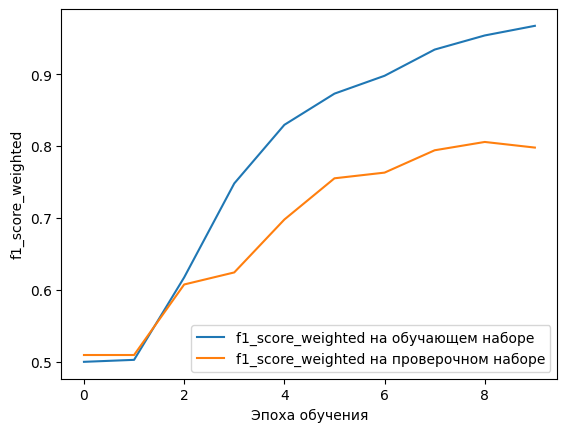

In [37]:
plt.plot(history_cnn.history['f1_score_weighted'], 
         label='f1_score_weighted на обучающем наборе')
plt.plot(history_cnn.history['val_f1_score_weighted'], 
         label='f1_score_weighted на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('f1_score_weighted')
plt.legend()
plt.show()

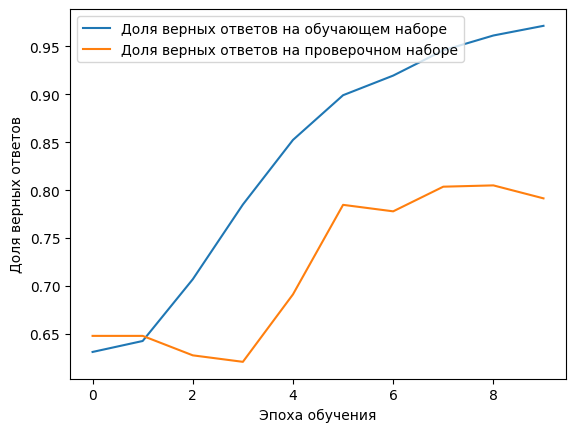

In [38]:
plt.plot(history_cnn.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history_cnn.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [39]:
cnn_loaded = load_model("best_model_cnn.h5")

In [40]:
cnn_loaded.evaluate(x_test, y_test, verbose=1)

58/58 [==============================] - 1s 4ms/step - loss: 0.8207 - accuracy: 0.8254 - precision: 0.8807 - recall: 0.7885 - f1_score_macro: 0.4020 - f1_score_micro: 0.8254 - f1_score_weighted: 0.8186


[0.8206735849380493,
 0.8253796100616455,
 0.8806783556938171,
 0.7885032296180725,
 0.40204137563705444,
 0.8253796696662903,
 0.8186473250389099]

In [41]:
predicted_cnn = cnn_loaded.predict(x_test)

58/58 [==============================] - 0s 2ms/step


In [42]:
import sklearn.metrics as sklearn_metrics
import numpy as np

In [43]:
report_cnn = sklearn_metrics.classification_report(np.argmax(y_test, axis=1), np.argmax(predicted_cnn, axis=1))
print(report_cnn)

              precision    recall  f1-score   support

           0       0.86      0.93      0.89      1212
           1       0.81      0.72      0.76       200
           2       0.72      0.67      0.70       140
           3       0.82      0.73      0.77       106
           4       0.81      0.63      0.71        70
           5       0.03      0.05      0.04        21
           6       1.00      0.65      0.79        23
           7       0.85      0.55      0.67        20
           8       0.00      0.00      0.00        13
           9       0.75      0.67      0.71        18
          10       0.00      0.00      0.00         5
          11       0.00      0.00      0.00         4
          12       0.00      0.00      0.00         5
          13       0.00      0.00      0.00         4
          14       0.00      0.00      0.00         3

    accuracy                           0.83      1844
   macro avg       0.44      0.37      0.40      1844
weighted avg       0.82   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [44]:
with open("CNN_10.txt", 'w') as w_file:
  w_file.write(report_cnn)

## Cеть LSTM

In [45]:
model_lstm = Sequential()
model_lstm.add(Embedding(num_words, 32, input_length=max_len))
model_lstm.add(LSTM(16))
model_lstm.add(Dense(15, activation='softmax'))

In [46]:
model_lstm.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
               metrics=['accuracy', metrics.Precision(), metrics.Recall(), metrics.F1Score(average='macro', name='f1_score_macro'), metrics.F1Score(average='micro', name='f1_score_micro'), metrics.F1Score(average='weighted', name='f1_score_weighted')]
              )

In [47]:
model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 11, 32)            320000    
                                                                 
 lstm (LSTM)                 (None, 16)                3136      
                                                                 
 dense_2 (Dense)             (None, 15)                255       
                                                                 
Total params: 323391 (1.23 MB)
Trainable params: 323391 (1.23 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Создаем callback для сохранения нейронной сети на каждой эпохе, если качество работы на проверочном наборе данных улучшилось. Сеть сохраняется в файл best_model.h5

In [48]:
model_lstm_save_path = 'best_model_lstm.h5'
checkpoint_callback_lstm = ModelCheckpoint(model_lstm_save_path, 
                                      #monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1)

In [49]:
history_lstm = model_lstm.fit(x_train, 
                              y_train, 
                              epochs=10,
                              batch_size=128,
                              validation_split=0.1,
                              callbacks=[checkpoint_callback_lstm])

Epoch 1/10
51/52 [============================>.] - ETA: 0s - loss: 2.4061 - accuracy: 0.5941 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - f1_score_macro: 0.0557 - f1_score_micro: 0.5941 - f1_score_weighted: 0.4946
Epoch 1: val_loss improved from inf to 1.64530, saving model to best_model_lstm.h5
52/52 [==============================] - 8s 95ms/step - loss: 2.3954 - accuracy: 0.5945 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - f1_score_macro: 0.0557 - f1_score_micro: 0.5945 - f1_score_weighted: 0.4942 - val_loss: 1.6453 - val_accuracy: 0.6477 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - val_f1_score_macro: 0.0524 - val_f1_score_micro: 0.6477 - val_f1_score_weighted: 0.5092
Epoch 2/10
 5/52 [=>............................] - ETA: 1s - loss: 1.6029 - accuracy: 0.6406 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - f1_score_macro: 0.0521 - f1_score_micro: 0.6406 - f1_score_weighted: 0.5003

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3052: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


52/52 [==============================] - ETA: 0s - loss: 1.4115 - accuracy: 0.6424 - precision_1: 0.6521 - recall_1: 0.5303 - f1_score_macro: 0.0521 - f1_score_micro: 0.6424 - f1_score_weighted: 0.5025
Epoch 2: val_loss improved from 1.64530 to 1.34201, saving model to best_model_lstm.h5
52/52 [==============================] - 4s 71ms/step - loss: 1.4115 - accuracy: 0.6424 - precision_1: 0.6521 - recall_1: 0.5303 - f1_score_macro: 0.0521 - f1_score_micro: 0.6424 - f1_score_weighted: 0.5025 - val_loss: 1.3420 - val_accuracy: 0.6477 - val_precision_1: 0.6477 - val_recall_1: 0.6477 - val_f1_score_macro: 0.0524 - val_f1_score_micro: 0.6477 - val_f1_score_weighted: 0.5092
Epoch 3/10
52/52 [==============================] - ETA: 0s - loss: 1.2796 - accuracy: 0.6424 - precision_1: 0.6518 - recall_1: 0.6424 - f1_score_macro: 0.0521 - f1_score_micro: 0.6424 - f1_score_weighted: 0.5025
Epoch 3: val_loss improved from 1.34201 to 1.24440, saving model to best_model_lstm.h5
52/52 [================

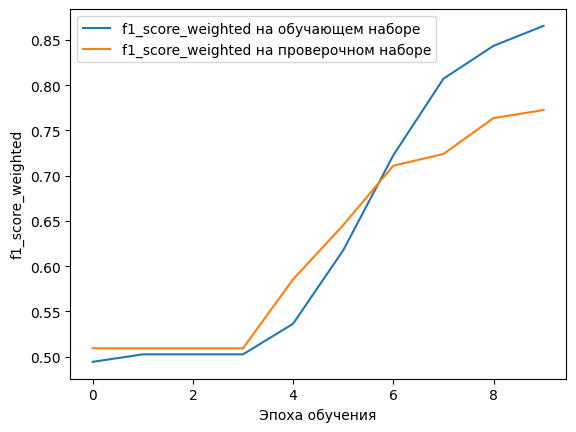

In [50]:
plt.plot(history_lstm.history['f1_score_weighted'], 
         label='f1_score_weighted на обучающем наборе')
plt.plot(history_lstm.history['val_f1_score_weighted'], 
         label='f1_score_weighted на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('f1_score_weighted')
plt.legend()
plt.show()

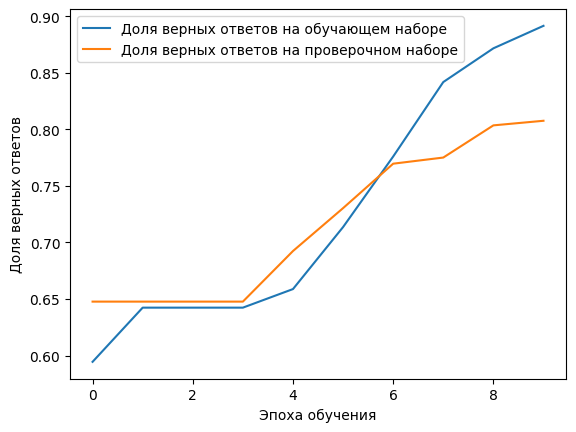

In [51]:
plt.plot(history_lstm.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history_lstm.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [52]:
lstm_loaded = load_model("best_model_lstm.h5")

In [53]:
lstm_loaded.evaluate(x_test, y_test, verbose=1)

58/58 [==============================] - 1s 4ms/step - loss: 0.7558 - accuracy: 0.8162 - precision_1: 0.8848 - recall_1: 0.7413 - f1_score_macro: 0.2344 - f1_score_micro: 0.8162 - f1_score_weighted: 0.7839


[0.7558183073997498,
 0.8161605000495911,
 0.8847896456718445,
 0.7413232326507568,
 0.23442476987838745,
 0.8161605000495911,
 0.7838771939277649]

In [54]:
predicted_lstm = lstm_loaded.predict(x_test)

58/58 [==============================] - 1s 3ms/step


In [55]:
report_lstm = sklearn_metrics.classification_report(np.argmax(y_test, axis=1), np.argmax(predicted_lstm, axis=1))
print(report_lstm)

              precision    recall  f1-score   support

           0       0.84      0.98      0.90      1212
           1       0.85      0.69      0.76       200
           2       0.66      0.52      0.58       140
           3       0.86      0.67      0.75       106
           4       0.48      0.56      0.52        70
           5       0.00      0.00      0.00        21
           6       0.00      0.00      0.00        23
           7       0.00      0.00      0.00        20
           8       0.00      0.00      0.00        13
           9       0.00      0.00      0.00        18
          10       0.00      0.00      0.00         5
          11       0.00      0.00      0.00         4
          12       0.00      0.00      0.00         5
          13       0.00      0.00      0.00         4
          14       0.00      0.00      0.00         3

    accuracy                           0.82      1844
   macro avg       0.25      0.23      0.23      1844
weighted avg       0.76   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [56]:
with open("LSTM_10.txt", 'w') as w_file:
  w_file.write(report_lstm)

## Cеть GRU

In [57]:
model_gru = Sequential()
model_gru.add(Embedding(num_words, 32, input_length=max_len))
model_gru.add(GRU(16))
model_gru.add(Dense(15, activation='softmax'))

In [58]:
model_gru.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy', metrics.Precision(), metrics.Recall(), metrics.F1Score(average='macro', name='f1_score_macro'), metrics.F1Score(average='micro', name='f1_score_micro'), metrics.F1Score(average='weighted', name='f1_score_weighted')]
              )

In [59]:
model_gru.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 11, 32)            320000    
                                                                 
 gru (GRU)                   (None, 16)                2400      
                                                                 
 dense_3 (Dense)             (None, 15)                255       
                                                                 
Total params: 322655 (1.23 MB)
Trainable params: 322655 (1.23 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Создаем callback для сохранения нейронной сети на каждой эпохе, если качество работы на проверочном наборе данных улучшилось. Сеть сохраняется в файл best_model_gru.h5

In [60]:
model_gru_save_path = 'best_model_gru.h5'
checkpoint_callback_gru = ModelCheckpoint(model_gru_save_path, 
                                      #monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1)

In [61]:
history_gru = model_gru.fit(x_train, 
                              y_train, 
                              epochs=10,
                              batch_size=128,
                              validation_split=0.1,
                              callbacks=[checkpoint_callback_gru])

Epoch 1/10
52/52 [==============================] - ETA: 0s - loss: 2.3749 - accuracy: 0.5991 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - f1_score_macro: 0.0586 - f1_score_micro: 0.5991 - f1_score_weighted: 0.4948
Epoch 1: val_loss improved from inf to 1.59367, saving model to best_model_gru.h5
52/52 [==============================] - 7s 84ms/step - loss: 2.3749 - accuracy: 0.5991 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - f1_score_macro: 0.0586 - f1_score_micro: 0.5991 - f1_score_weighted: 0.4948 - val_loss: 1.5937 - val_accuracy: 0.6477 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - val_f1_score_macro: 0.0524 - val_f1_score_micro: 0.6477 - val_f1_score_weighted: 0.5092
Epoch 2/10
 2/52 [>.............................] - ETA: 7s - loss: 1.6585 - accuracy: 0.6211 - precision_2: 0.3333 - recall_2: 0.0039 - f1_score_macro: 0.0511 - f1_score_micro: 0.6211 - f1_score_weighted: 0.4759        

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3052: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


52/52 [==============================] - ETA: 0s - loss: 1.3364 - accuracy: 0.6424 - precision_2: 0.7277 - recall_2: 0.5770 - f1_score_macro: 0.0521 - f1_score_micro: 0.6424 - f1_score_weighted: 0.5025
Epoch 2: val_loss improved from 1.59367 to 1.19229, saving model to best_model_gru.h5
52/52 [==============================] - 2s 47ms/step - loss: 1.3364 - accuracy: 0.6424 - precision_2: 0.7277 - recall_2: 0.5770 - f1_score_macro: 0.0521 - f1_score_micro: 0.6424 - f1_score_weighted: 0.5025 - val_loss: 1.1923 - val_accuracy: 0.6477 - val_precision_2: 0.7836 - val_recall_2: 0.6477 - val_f1_score_macro: 0.0524 - val_f1_score_micro: 0.6477 - val_f1_score_weighted: 0.5092
Epoch 3/10
52/52 [==============================] - ETA: 0s - loss: 1.0614 - accuracy: 0.6957 - precision_2: 0.8526 - recall_2: 0.6422 - f1_score_macro: 0.0967 - f1_score_micro: 0.6957 - f1_score_weighted: 0.5949
Epoch 3: val_loss improved from 1.19229 to 1.03240, saving model to best_model_gru.h5
52/52 [==================

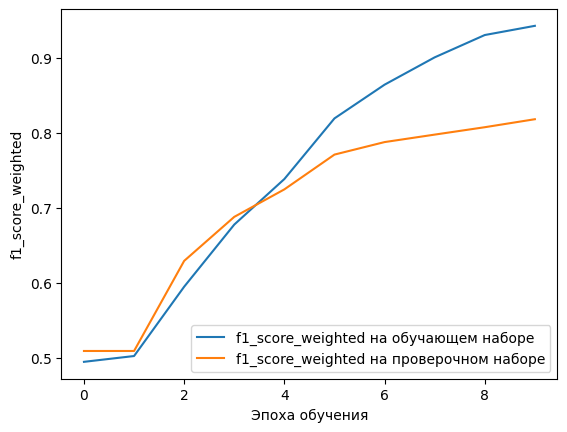

In [62]:
plt.plot(history_gru.history['f1_score_weighted'], 
         label='f1_score_weighted на обучающем наборе')
plt.plot(history_gru.history['val_f1_score_weighted'], 
         label='f1_score_weighted на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('f1_score_weighted')
plt.legend()
plt.show()

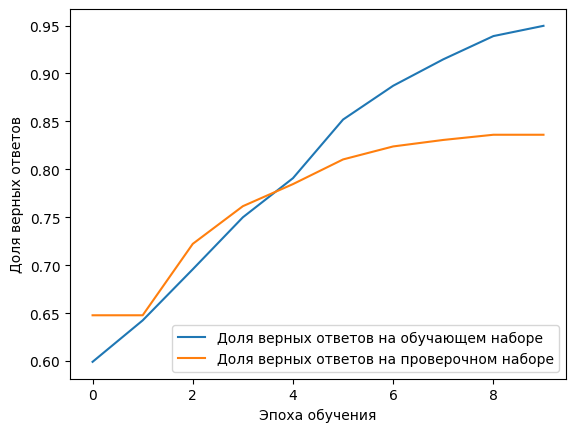

In [63]:
plt.plot(history_gru.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history_gru.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [64]:
gru_loaded = load_model("best_model_gru.h5")

In [65]:
gru_loaded.evaluate(x_test, y_test, verbose=1)

58/58 [==============================] - 2s 6ms/step - loss: 0.6345 - accuracy: 0.8557 - precision_2: 0.8831 - recall_2: 0.8238 - f1_score_macro: 0.4315 - f1_score_micro: 0.8557 - f1_score_weighted: 0.8385


[0.634497344493866,
 0.8557483553886414,
 0.8831395506858826,
 0.8237527012825012,
 0.43149539828300476,
 0.8557483553886414,
 0.8384604454040527]

In [66]:
predicted_gru = gru_loaded.predict(x_test)

58/58 [==============================] - 0s 2ms/step


In [67]:
report_gru = sklearn_metrics.classification_report(np.argmax(y_test, axis=1), np.argmax(predicted_gru, axis=1))
print(report_gru)

              precision    recall  f1-score   support

           0       0.85      0.99      0.91      1212
           1       0.85      0.69      0.76       200
           2       0.91      0.63      0.74       140
           3       0.85      0.69      0.76       106
           4       1.00      0.61      0.76        70
           5       1.00      0.38      0.55        21
           6       1.00      0.70      0.82        23
           7       1.00      0.30      0.46        20
           8       1.00      0.08      0.14        13
           9       1.00      0.39      0.56        18
          10       0.00      0.00      0.00         5
          11       0.00      0.00      0.00         4
          12       0.00      0.00      0.00         5
          13       0.00      0.00      0.00         4
          14       0.00      0.00      0.00         3

    accuracy                           0.86      1844
   macro avg       0.63      0.36      0.43      1844
weighted avg       0.85   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [68]:
with open("GRU_10.txt", 'w') as w_file:
  w_file.write(report_gru)

## Загружаем набор данных для тестирования


In [69]:
test

,img_emoji,word_count,count_emoji,emotion,tonality,class,clean_text
5432,🤣,2,1,smile,positive/negative,0,раунд🤣
5093,🤣,5,1,smile,positive/negative,0,не ждём ни разу🤣
6314,😅,6,1,smile,positive/negative,0,😅 нет! а вы?
3812,🤣,8,1,smile,positive/negative,0,просто одмен на нее вялого дергает.🤣
423,😅,11,1,smile,positive/negative,0,"в фотографиях ""спустя годы"" своя, особая, атмо..."
...,...,...,...,...,...,...,...
5759,😬,7,1,no_emotion,neutral/skeptical,1,ну может и так))😬
5802,😆,10,1,smile,positive/negative,0,я так и делаю. через час - сухая 😆
7911,🙄,9,1,no_emotion,neutral/skeptical,1,судя по аватарке сложно вас назвать девочкой п...
1758,😂,6,1,smile,positive/negative,0,"интересный дизайн платья, скатерть! 😂"


Преобразуем посты в числовое представление

Нужно использовать токенизатор, обученный на наборе данных train.

In [70]:
test_sequences = tokenizer.texts_to_sequences(test['clean_text'])

In [71]:
x_test = pad_sequences(test_sequences, maxlen=max_len)

In [72]:
x_test[:5]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    1, 1368,  166],
       [   0,    0,    0,    0,    0,    0,    0,   16,   48,    5,   27],
       [   0,    0,    0,    0,    0,    0,    0,   38,   10,  302,    4],
       [   0,    0,    0,    0,    0,    3, 2739, 3026, 2144, 1102,   16]],
      dtype=int32)

Правильные ответы

In [73]:
y_test = utils.to_categorical(test['class'], nb_classes)

In [74]:
y_test

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

## Оцениваем качество работы сети на тестовом наборе данных


### Одномерная сверточная сеть

In [75]:
model_cnn.load_weights(model_cnn_save_path)

In [76]:
loss, accuracy, precision, recall, f1_score_macro, f1_score_micro, f1_score_weighted = model_cnn.evaluate(x_test, y_test, verbose=1)

58/58 [==============================] - 0s 5ms/step - loss: 0.8207 - accuracy: 0.8254 - precision: 0.8807 - recall: 0.7885 - f1_score_macro: 0.4020 - f1_score_micro: 0.8254 - f1_score_weighted: 0.8186


### Сеть LSTM

In [77]:
model_lstm.load_weights(model_lstm_save_path)

In [78]:
loss, accuracy, precision, recall, f1_score_macro, f1_score_micro, f1_score_weighted = model_lstm.evaluate(x_test, y_test, verbose=1)

58/58 [==============================] - 0s 4ms/step - loss: 0.7558 - accuracy: 0.8162 - precision_1: 0.8848 - recall_1: 0.7413 - f1_score_macro: 0.2344 - f1_score_micro: 0.8162 - f1_score_weighted: 0.7839


### Сеть GRU

In [79]:
model_gru.load_weights(model_gru_save_path)

In [80]:
loss, accuracy, precision, recall, f1_score_macro, f1_score_micro, f1_score_weighted = model_gru.evaluate(x_test, y_test, verbose=1)

58/58 [==============================] - 0s 6ms/step - loss: 0.6345 - accuracy: 0.8557 - precision_2: 0.8831 - recall_2: 0.8238 - f1_score_macro: 0.4315 - f1_score_micro: 0.8557 - f1_score_weighted: 0.8385


In [83]:
#test['clean_text'][592]
test['clean_text'][2384]

'как надоел этот чёртов опыт😔'

In [84]:
test['class'][2384], test['emotion'][2384], test['tonality'][2384]
#test['class'][592], test['emotion'][592], test['tonality'][592]

(4, 'sadness', 'negative')

In [85]:
text = test['clean_text'][2384]
#text = test['clean_text'][592]

In [87]:
sequence = tokenizer.texts_to_sequences([text])

In [88]:
sequence

[[15, 82]]

In [89]:
data = pad_sequences(sequence, maxlen=max_len)

In [90]:
data

array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0, 15, 82]], dtype=int32)

In [91]:
emoji_dict = {"0":"smile positive/negative", "1":"no_emotion neutral/skeptical", "2":"joy positive",
              "3":"no_emotion positive/negative", "4":"sadness negative", "5":"fear negative",
              "6":"shame negative","7":"anger negative", "8":"disgust negative",
              "9":"surprise positive/negative","10":"disgust neutral/skeptical", "11":"surprise negative",
              "12":"no_emotion negative","13":"sadness positive/negative", "14":"fear positive/negative"}

### Одномерная сверточная сеть

In [92]:
result_cnn = model_cnn.predict(data)

1/1 [==============================] - 0s 107ms/step


In [93]:
result_cnn

array([[8.34785104e-01, 3.61423846e-03, 1.50719145e-02, 3.68711501e-02,
        1.10046344e-03, 2.77571343e-02, 1.70163426e-03, 1.36274546e-02,
        4.17695381e-02, 4.31997143e-03, 8.39864649e-03, 2.91315978e-03,
        1.66690361e-03, 5.81799354e-03, 5.84632915e-04]], dtype=float32)

### Сеть LSTM

In [94]:
result_lstm = model_lstm.predict(data)

1/1 [==============================] - 0s 317ms/step


In [95]:
result_lstm

array([[0.61514246, 0.11190922, 0.13777025, 0.06648818, 0.02547133,
        0.00897669, 0.00940948, 0.00663213, 0.00398992, 0.00476904,
        0.00223641, 0.00279462, 0.00174053, 0.00146353, 0.0012062 ]],
      dtype=float32)

### Сеть GRU

In [96]:
result_gru = model_gru.predict(data)

1/1 [==============================] - 0s 280ms/step


In [97]:
result_gru

array([[0.6791172 , 0.06820127, 0.05998535, 0.04343855, 0.08537231,
        0.00622144, 0.01390872, 0.01016257, 0.00530892, 0.00453597,
        0.00267783, 0.00480647, 0.00464905, 0.00463565, 0.00697875]],
      dtype=float32)